In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvx_portfolio as cp

plotdir = '../portfolio/plots/'

## Download data using ee103 code (to be integrated) 

In [2]:
datadir= '../equity_data_tool/'
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])

spread = pd.DataFrame(data=2.5*1e-4, index=volumes.index, columns=volumes.columns)
nonlin_coeff = pd.DataFrame(data=1, index=volumes.index, columns=volumes.columns) # fix volatility model

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

## Simulations

In [3]:
simulated_tcost = cp.TcostModel(volumes, sigmas, spread, nonlin_coeff, cash_key='USDOLLAR')
simulator = cp.MarketSimulator(returns, volumes, [simulated_tcost], cash_key='USDOLLAR')

policies = [cp.PeriodicRebalance(target=w_b, period=p) for p in ['day', 'week', 'month', 'quarter', 'year']]
policies.append(cp.Hold())

res = pd.DataFrame(index=['Daily','Weekly','Monthly','Quarterly','Annually','Hold'])
for label, fund_val in [('\$100M',1E8), ('\$10B',1E10)]:
    res[label] = simulator.run_multiple_backtest(fund_val*w_b, start_time="2012-01-01", end_time="2016-12-31", policies=policies)

## Results 

In [4]:
benchmark_returns = returns.loc[returns.index>'2012-01-01'].mean(1)

In [5]:
table=pd.DataFrame()
table[r'Active return']=res.applymap(lambda res: 100*250*(res.returns - benchmark_returns).mean()).unstack()
table[r'Trans. costs']=\
    res.applymap(lambda res: (res.simulator_TcostModel.sum(1)/res.v).mean() * 100 * 250).unstack()
table[r'Active risk']= \
res.applymap(lambda res: np.std(returns.loc[returns.index>'2012-01-01'].mean(1) - res.returns)*100*np.sqrt(250)).unstack()

table_print=pd.DataFrame(table,copy=True)
table_print.ix[:,:]=table_print.ix[:,:].applymap(lambda x: r'%.2f%%'%x )

table_print

Active return Trans. costs Active risk
\$100M Daily             0.08%        0.08%       0.13%
       Weekly            0.14%        0.05%       0.15%
       Monthly           0.15%        0.03%       0.22%
       Quarterly         0.22%        0.02%       0.35%
       Annually          0.21%        0.01%       0.74%
       Hold              0.24%        0.00%       2.06%
\$10B  Daily            -0.20%        0.37%       0.13%
       Weekly           -0.06%        0.24%       0.16%
       Monthly           0.00%        0.18%       0.22%
       Quarterly         0.11%        0.13%       0.35%
       Annually          0.15%        0.08%       0.75%
       Hold              0.24%        0.00%       2.06%

In [12]:
print(table_print.to_latex(float_format='%.2f', escape=False).replace('%',r'\%'))

\begin{tabular}{lllll}
\toprule
       &       & Active return & Trans. costs & Active risk \\
\midrule
\$100M & Daily &         0.08\% &        0.08\% &       0.13\% \\
       & Weekly &         0.14\% &        0.05\% &       0.15\% \\
       & Monthly &         0.15\% &        0.03\% &       0.22\% \\
       & Quarterly &         0.22\% &        0.02\% &       0.35\% \\
       & Annually &         0.21\% &        0.01\% &       0.74\% \\
       & Hold &         0.24\% &        0.00\% &       2.06\% \\
\$10B & Daily &        -0.20\% &        0.37\% &       0.13\% \\
       & Weekly &        -0.06\% &        0.24\% &       0.16\% \\
       & Monthly &         0.00\% &        0.18\% &       0.22\% \\
       & Quarterly &         0.11\% &        0.13\% &       0.35\% \\
       & Annually &         0.15\% &        0.08\% &       0.75\% \\
       & Hold &         0.24\% &        0.00\% &       2.06\% \\
\bottomrule
\end{tabular}



# Plots 

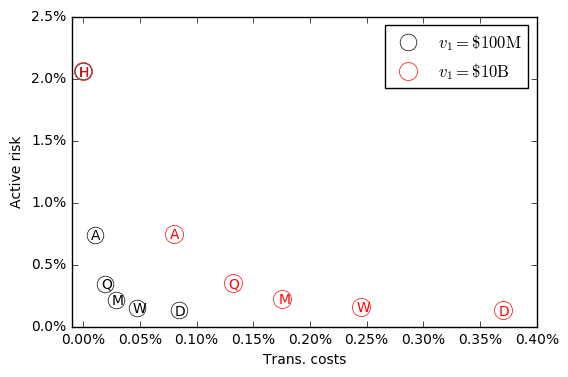

In [13]:
plt.figure(figsize=(6,4))
colors=['k','r']
offsetx = 0.0035
offsety = 0.04
data=table.ix[:,:]

for j,initval in enumerate(data.index.levels[0]):
    x=data.loc[initval].ix[:,1].values
    y=data.loc[initval].ix[:,2].values
    line,=plt.plot(x,y, colors[j]+'o', 
                   markersize=12+j,
                   fillstyle='none', 
                   label='$v_1 = %s\mathrm{%s}$'%(initval[:-1],initval[-1:]))
    for i in range(len(x)):
        plt.text(x[i]-offsetx,y[i]-offsety, data.index.levels[1][i][0],color=colors[j] )


plt.legend(loc='upper right',numpoints=1)
plt.ylabel(r'Active risk')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter( '%.2f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter( '%.1f%%'))

plt.xlabel(r'Trans. costs')
plt.xlim([-0.01,0.4])
#plt.ylim([- 0.5, 14])
plt.savefig(plotdir+'basic_frontier.png')

In [14]:
# res.loc[:, '\$10B'].apply(lambda x: 100*x.simulator_TcostModel.sum(1)/x.v).T.ix[:,:-1].plot(figsize=(8,5))
# import matplotlib.ticker as mtick
# ax = plt.gca()
# ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f%%'))

# #plt.ylabel("$\phi_t^{\mathrm{trade}}(z_t)$",fontsize=20)
# plt.ylabel("Daily trans. cost")

# plt.savefig(plotdir+'basic_example_tcost_time.png')